# Quantifying Crowded Trades(QCT): A Comprehensive Analysis
### sector_centrality
### Collins Emezie Ugwuozor, Jayesh Chandra Gupta, Emmanuel Effiong Asuquo

In [ ]:
#pip install yahoo_fin

In [ ]:
#Import the neccessary libraries
!pip install yahoo_fin
import pandas as pd
import numpy as np
import seaborn as sns
from pandas_datareader import data
import yfinance as yf
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
%matplotlib inline
import matplotlib.pyplot as plt
import yfinance as yf
import yahoo_fin
from yahoo_fin import stock_info
import yahoo_fin.stock_info as si
import requests
from bs4 import BeautifulSoup

In [ ]:
# Pick up table of S&P 500 listed companies from Wikipedia.
data = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')

In [ ]:
table = data[0]
table.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [ ]:
table['GICS Sector'].unique()

array(['Industrials', 'Health Care', 'Information Technology',
       'Utilities', 'Financials', 'Materials', 'Consumer Discretionary',
       'Real Estate', 'Communication Services', 'Consumer Staples',
       'Energy'], dtype=object)

In [ ]:
# Select sectors of S&P 500
industrials_sector = table[table['GICS Sector'] == 'Industrials'] # XLI
health_sector = table[table['GICS Sector'] == 'Health Care'] # XLV
tech_sector = table[table['GICS Sector'] == 'Information Technology'] # XLK
consumer_staples_sector = table[table['GICS Sector'] == 'Consumer Staples'] # XLP
utilities_sector = table[table['GICS Sector'] == 'Utilities'] # XLU
financial_sector = table[table['GICS Sector'] == 'Financials'] # XLF
consumer_discretionary_sector = table[table['GICS Sector'] == 'Consumer Discretionary'] # XLY
materials_sector = table[table['GICS Sector'] == 'Materials'] # XLB
real_estate_sector = table[table['GICS Sector'] == 'Real Estate'] # XLRE
communication_services_sector = table[table['GICS Sector'] == 'Communication Services'] # XLC *XTL
energy_sector = table[table['GICS Sector'] == 'Energy'] # XLE

In [ ]:
# Define dates for five year historical prices
start_date = "2018-01-01"
end_date = "2023-01-01"

In [ ]:
# Sector ETFs for centrality across sectors
symbols = ['XLB', 'XLI', 'XLY', 'XLP', 'XLE', 'XLV', 'XLF', 'XLK', 'XTL', 'XLU', 'XLRE']

In [ ]:
# Get the  "Adj Close" data from Yahoo Finance
df_sectors = yf.download(symbols, start=start_date, end=end_date)['Adj Close']
# Calculate daily returns and drop NaNs
df_sectors = df_sectors.pct_change()
df_sectors.dropna(inplace=True)

# Standardize the data and calculate covariance matrix
scaler = StandardScaler()
df_sectors_scaled = scaler.fit_transform(df_sectors)
df_sector_cov = np.cov(df_sectors_scaled.T)

df_sectors.head(10)

[*********************100%%**********************]  11 of 11 completed


,XLB,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY,XTL
Date,,,,,,,,,,,
2018-01-03,0.007004,0.014976,0.005372,0.005386,0.008341,-0.000354,0.000305,-0.007856,0.009568,0.004591,0.000723
2018-01-04,0.008735,0.006036,0.009262,0.007317,0.005055,0.002831,-0.017094,-0.008304,0.001422,0.003279,0.005777
2018-01-05,0.008018,-0.000400,0.002824,0.006875,0.010517,0.004411,0.002174,-0.000389,0.008518,0.007922,0.002154
2018-01-08,0.001432,0.006003,-0.001408,0.004123,0.003771,0.002459,0.006818,0.009351,-0.003636,0.001179,0.009314
2018-01-09,-0.001589,-0.002519,0.007755,0.006415,-0.002555,-0.001402,-0.011388,-0.009844,0.011773,0.001963,-0.006957
2018-01-10,-0.006046,-0.001196,0.008395,-0.000128,-0.003465,-0.004913,-0.015566,-0.010916,-0.001745,-0.000686,-0.012580
2018-01-11,0.013126,0.020495,0.004856,0.012750,0.004082,-0.001410,-0.006325,-0.003745,0.004313,0.016270,0.013899
2018-01-12,0.001580,0.009651,0.008975,0.009316,0.005872,0.000353,-0.007320,-0.005737,0.007660,0.012923,0.009424
2018-01-16,-0.011674,-0.012658,-0.002737,-0.008981,-0.003892,0.004590,0.004809,-0.002188,0.004953,-0.007141,-0.011176


#### Step 1: Calculate Asset Centrality for Sectors

## Absorbtion Ratio $$AR = \frac{\sum_{i=1}^n \sigma^2E_i}{\sum_{j=1}^N \sigma^2A_j}$$

- $N$ = number of sectors
- $n$ = number of eigenvectors
- $\sigma^2E_i$ = variance of the $i^{th}$ eigenvector
- $\sigma^2A_j$ = variance of the $j^{th}$ sector

The fraction of the total variance that is "absorbed"/explained by a fixed number of eigenvectors

We will Calculate the Absorbsion Ratio(AR) for Sectors using:
- PCA
- Eigen decomposition of Covariance matrix
- Eigen values and sum of variance of original data

The absorption ratio:
- Measures the degree of concentration within a set of sectors.
- Represents the portion of variability in asset returns that can be attributed to a specific number of factors in a Principal Component Analysis (PCA).
- When elevated, indicates a propensity for shocks to rapidly disseminate across a wide spectrum.

In [ ]:
# AR calculation using PCA
n = 2
sectors_pca = PCA(n_components=n)
sectors_pca.fit(df_sectors_scaled)
ar_pca = np.sum(sectors_pca.explained_variance_ratio_)
print(f'The percent of explained variance in the first {n} principal components = {ar_pca}')

# AR calculation using eigen decompostion of covariance matrix
w, v = np.linalg.eig(df_sector_cov)
sorted_eigenvalues = w.argsort()[::-1]
var_ratio = [eig/np.sum(w) for eig in w[sorted_eigenvalues]]
print(f'The percent of explained variance in the first {n} eigen vectors = {np.sum(var_ratio[0:2])}')

# AR calculation using eigen values and sum of variances of original data
ar_num = np.sum(w[sorted_eigenvalues][0:n])
ar_denom = np.sum(np.var(df_sectors_scaled, axis=0))
ar = ar_num/ar_denom
print(f'The absorbtion ratio of the first {n} eigen vectors over original X variance = {ar}')

The percent of explained variance in the first 2 principal components = 0.8072519198666176
The percent of explained variance in the first 2 eigen vectors = 0.8072519198666173
The absorbtion ratio of the first 2 eigen vectors over original X variance = 0.8078941250534647


## Centrality  $$C_i = \frac {\sum_{j=1}^n \biggl( AR^j  \frac{| EV_i^j |}{\sum_{k=1}^N | EV_k^j |} \biggr)}{\sum_{j=1}^n AR^j} $$

- $C_i$ = sector's centrality score
- $AR^j$ = absorbtion ratio of the $j^th$ eigenvector
- $EV_i^j$ = absolute value of the exposure of the $i^th$ sector within the $j^th$ eigenvector
- $n$ = number of eigenvectors in the numerator of the absorbtion ratio
- $N$ = total number of sectors

In [ ]:
def centrality_score(X, n=2):
    N = X.shape[1]
    pca_model = PCA(n_components=n)
    pca_model.fit(X)
    EV = pca_model.components_
    AR = pca_model.explained_variance_ratio_
    C_list = []
    for i in range(N):
        C_num = []
        C_denom = []
        for j in range(n):
            C_num.append(AR[j] * \
                    (abs(EV[j][i])/\
                     sum([abs(EV[j][k]) for k in range(N)])))
            C_denom.append(AR[j])

        C_list.append(sum(C_num)/sum(C_denom))
    return C_list

To assess sector centrality, we will follow these steps:
- Gather five years of historical daily returns for individual sectors.
- Assign weights to each historical return based on the square root of their respective market capitalization weights.
- Calculate the covariance matrix encompassing the sectors.
- Determine sector centrality using the top two eigenvectors.

In [ ]:
tickers= symbols
tickers

['XLB', 'XLI', 'XLY', 'XLP', 'XLE', 'XLV', 'XLF', 'XLK', 'XTL', 'XLU', 'XLRE']

In [ ]:
# Get the Market Capitalization from yahoo finance
tickers= symbols
def get_market_cap(ticker):
    try:
        stock_data = yf.Ticker(ticker)
        market_cap = stock_data.info.get('marketCap')

        if market_cap is not None:
            return market_cap
        else:
            return None
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        return None

In [ ]:
market_cap = [get_market_cap(ticker) for ticker in tickers]
print(market_cap)

[None, None, None, None, None, None, None, None, None, None, None]


In [ ]:
# Sector's Mkt Cap (USD m) picked manually From bloomberg as of 2Jan'18
market_cap = [5155.15,12969,13240.4,9152.23,18812.3,16832,32902.2,19697.5,44.97,7122.59,2392.39]

In [ ]:
weights=[]
for i in range(11):
    weights.append(market_cap[i]/(np.array(market_cap)).sum())
weights

[0.03726954014774213,
 0.09376034958751302,
 0.09572245606280418,
 0.066166727142056,
 0.13600492131584324,
 0.12168819525460861,
 0.2378689007786468,
 0.14240454051970372,
 0.00032511395797289386,
 0.051493293882992085,
 0.017295961350117222]

In [ ]:
# multiply the returns by the square root of market weights of each sector
weights = np.array([.023,.166,.131,.063,.234,.069, .019,.061,.160,.074,.0002])
sector_weights = dict(zip(df_sectors.columns, weights*100))
weighted_df = df_sectors.copy()
for sector in df_sectors.columns:
    weighted_df.loc[:,sector] = weighted_df.loc[:, sector] * sector_weights[sector]**.5
weighted_df.head()

,XLB,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY,XTL
Date,,,,,,,,,,,
2018-01-03,0.010623,0.061019,0.019445,0.013519,0.040349,-0.000929,0.000421,-0.019403,0.038273,0.012490,0.000102
2018-01-04,0.013247,0.024594,0.033524,0.018366,0.024453,0.007436,-0.023562,-0.020510,0.005687,0.008919,0.000817
2018-01-05,0.012160,-0.001631,0.010221,0.017257,0.050874,0.011586,0.002996,-0.000962,0.034070,0.021551,0.000305
2018-01-08,0.002172,0.024456,-0.005096,0.010348,0.018240,0.006460,0.009397,0.023096,-0.014545,0.003207,0.001317
2018-01-09,-0.002409,-0.010264,0.028067,0.016103,-0.012358,-0.003683,-0.015697,-0.024312,0.047092,0.005339,-0.000984


In [ ]:
print(f'Not scaled - {sorted(zip(symbols,[np.around(C,3) for C in centrality_score(df_sectors)]), key=lambda x: x[1], reverse=True)}')

unscaled_scores = dict(zip(symbols, [np.around(C,3) for C in centrality_score(df_sectors)]))

Not scaled - [('XLI', 0.15), ('XLE', 0.107), ('XLY', 0.099), ('XLU', 0.094), ('XLP', 0.088), ('XLB', 0.087), ('XLF', 0.086), ('XLRE', 0.086), ('XLK', 0.071), ('XTL', 0.071), ('XLV', 0.061)]


In [ ]:
print(f'Scaled - {sorted(zip(symbols,[np.around(C,3) for C in centrality_score(df_sectors_scaled)]), key=lambda x: x[1], reverse=True)}')

scaled_scores = dict(zip(symbols, [np.around(C,3) for C in centrality_score(df_sectors_scaled)]))

Scaled - [('XLP', 0.095), ('XLB', 0.094), ('XLV', 0.094), ('XLY', 0.093), ('XLF', 0.093), ('XLK', 0.092), ('XLU', 0.09), ('XLRE', 0.09), ('XTL', 0.089), ('XLE', 0.087), ('XLI', 0.083)]


In [ ]:
print(f'Weighted - {sorted(zip(symbols,[np.around(C,3) for C in centrality_score(weighted_df)]), key=lambda x: x[1], reverse=True)}')

weighted_scores = dict(zip(symbols, [np.around(C,3) for C in centrality_score(weighted_df)]))

Weighted - [('XLI', 0.225), ('XLE', 0.2), ('XLY', 0.118), ('XTL', 0.101), ('XLU', 0.093), ('XLP', 0.072), ('XLV', 0.053), ('XLK', 0.053), ('XLB', 0.043), ('XLF', 0.037), ('XLRE', 0.004)]


In [ ]:
# Create a dataframe of scores computed from different methods
for sector in unscaled_scores:
    unscaled_scores[sector] = [unscaled_scores[sector], scaled_scores[sector], weighted_scores[sector]]
scores_df = pd.DataFrame(data=unscaled_scores, index=['Unscaled', 'Scaled', 'Weighted'])
scores_df

,XLB,XLI,XLY,XLP,XLE,XLV,XLF,XLK,XTL,XLU,XLRE
Unscaled,0.087,0.150,0.099,0.088,0.107,0.061,0.086,0.071,0.071,0.094,0.086
Scaled,0.094,0.083,0.093,0.095,0.087,0.094,0.093,0.092,0.089,0.090,0.090
Weighted,0.043,0.225,0.118,0.072,0.200,0.053,0.037,0.053,0.101,0.093,0.004


In [ ]:
# rolling 1-year centrality score
rolling_Cs = [centrality_score(weighted_df.iloc[i-252:i,:]) for i in range(252, weighted_df.shape[0]+1)]

<Axes: title={'center': 'Sector EFT 1-year Rolling Centrality Score'}>

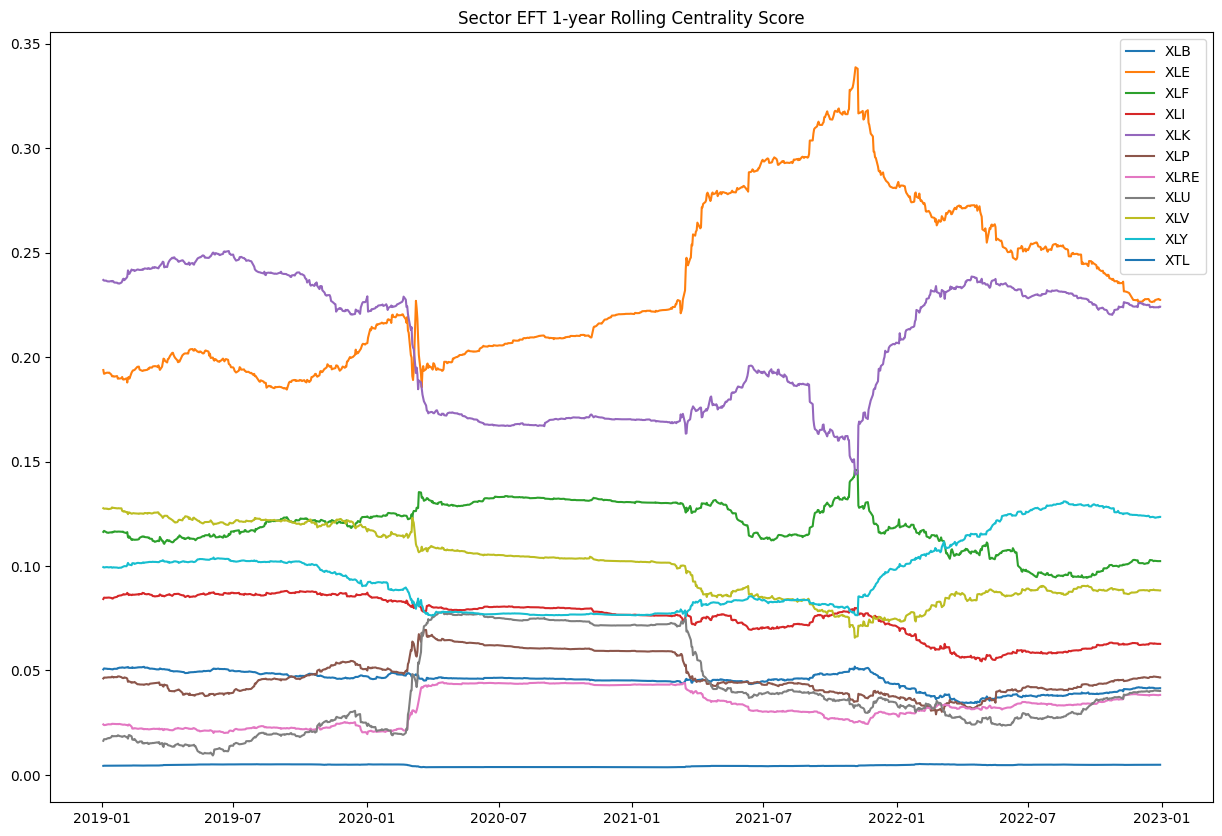

In [ ]:
pd.DataFrame(data=rolling_Cs, columns=df_sectors.columns, index=[date.date() for date in df_sectors.index[251:]]).plot(figsize=(15,10), title='Sector EFT 1-year Rolling Centrality Score')

# Relative Value

$$RV_{sector} =  (Sector-Current-Price)/(Sector-200Day-SMA)/(MktCap-weighted-Ave-of Normalized Valuations Across All Sectors) $$

- $RV$ = Relative Value

ACROSS SECTORS:
- We will use the current price of the sector
- The price will be normalize by dividing it by the sector's 200 Day SMA
- We will further divide each sector's current market cap by market cap weighted average of the normalized value of all sectors to establish a cross-sectional relative value measure


In [ ]:
# Getting current price of the sector from yahoo finance
sectors = symbols
sector_current_price=[]
for sector in sectors:
    print(sector)
    try:
       sector_current_price.append(yahoo_fin.stock_info.get_live_price(sector))
    except:
        print('Yahoo Finance current price error with: ', sector)

XLB
XLI
XLY
XLP
XLE
XLV
XLF


/usr/local/lib/python3.10/dist-packages/yahoo_fin/stock_info.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame['ticker'] = ticker.upper()


XLK
XTL
XLU
XLRE


In [ ]:
sector_current_price

[85.16999816894531,
 113.0199966430664,
 179.2100067138672,
 71.23999786376953,
 84.30000305175781,
 134.16000366210938,
 37.349998474121094,
 191.6999969482422,
 77.66000366210938,
 63.970001220703125,
 40.0]

In [ ]:
# Getting sector's 200 Day SMA from yahoo finance
sectors = symbols
sector_200DaySMA=[]
for sector in sectors:
    print(sector)
    try:
       sector_200DaySMA.append(yahoo_fin.stock_info.get_data(sector, interval='1d')['close'][-200:].mean())
    except:
        print('Sector_200DaySMA error with: ', sector)

XLB
XLI
XLY
XLP
XLE
XLV
XLF
XLK
XTL
XLU
XLRE


/usr/local/lib/python3.10/dist-packages/yahoo_fin/stock_info.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame['ticker'] = ticker.upper()


In [ ]:
sector_200DaySMA

[80.12284992218018,
 103.31915027618408,
 159.7861993408203,
 72.55224994659424,
 84.47075023651124,
 130.91950050354004,
 33.60204999923706,
 165.312200088501,
 73.53299991607666,
 64.54130010604858,
 36.45455003738403]

In [ ]:
#Normalized by dividing it's current price with the sector's 200 Day SMA
normalize=[]
for i in range(11):
    normalize.append(sector_current_price[i]/sector_200DaySMA[i])
normalize

[1.0629926201035935,
 1.0938920455786836,
 1.1215612327796618,
 0.9819130063672641,
 0.9979786235557829,
 1.0247518753593299,
 1.1115392803406081,
 1.1596240135066518,
 1.056124512133911,
 0.9911483207743453,
 1.0972567199150756]

In [ ]:
weights=[]
for i in range(11):
    weights.append(normalize[i] * (np.array(market_cap)).sum()/(np.array(market_cap)).sum())
weights

[1.0629926201035935,
 1.0938920455786836,
 1.1215612327796618,
 0.9819130063672641,
 0.997978623555783,
 1.0247518753593299,
 1.1115392803406081,
 1.1596240135066518,
 1.056124512133911,
 0.9911483207743454,
 1.0972567199150756]

In [ ]:
weights = np.array(weights)
weighted_average = weights.mean()

In [ ]:
# Establish a cross-sectional relative value measure
relative_measure=[]
for i in range(11):
    relative_measure.append(normalize[i]/weighted_average)
relative_measure

[0.9994988000332113,
 1.0285525658825532,
 1.0545690394518399,
 0.9232621685609063,
 0.9383681672273435,
 0.9635422206916322,
 1.0451457102138175,
 1.0903582847796636,
 0.9930409323637939,
 0.9319458465970789,
 1.0317162641981619]

In [ ]:
relative_scores = dict(zip(symbols, [np.around(r,3) for r in relative_measure]))

In [ ]:
relative_scores

{'XLB': 0.999,
 'XLI': 1.029,
 'XLY': 1.055,
 'XLP': 0.923,
 'XLE': 0.938,
 'XLV': 0.964,
 'XLF': 1.045,
 'XLK': 1.09,
 'XTL': 0.993,
 'XLU': 0.932,
 'XLRE': 1.032}

In [ ]:
# Create a dataframe of computed scores
for asset in relative_scores:
    relative_scores[asset] = [relative_scores[asset]]
scores_df = pd.DataFrame(data = relative_scores, index=['Weighted_score'])
scores_df

,XLB,XLI,XLY,XLP,XLE,XLV,XLF,XLK,XTL,XLU,XLRE
Weighted_score,0.999,1.029,1.055,0.923,0.938,0.964,1.045,1.09,0.993,0.932,1.032


In [ ]:
# Define relative values for each sector
relative_values = np.array([0.999,	1.029,	1.055,	0.923,	0.938,	0.964,	1.045,	1.09,	0.993,	0.932,	1.032])
# Create a dictionary with sector names and their corresponding relative values
sector_relative_values = dict(zip(df_sectors.columns, relative_values))

# Create a copy of the original DataFrame
weighted_df = df_sectors.copy()

# Iterate over each sector
for sector in df_sectors.columns:
    # Multiply the returns in each sector by the square root of its relative value
    weighted_df.loc[:, sector] = weighted_df.loc[:, sector] * sector_relative_values[sector] ** 0.5

# Display the first few rows of the resulting DataFrame
weighted_df.head()

,XLB,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY,XTL
Date,,,,,,,,,,,
2018-01-03,0.007001,0.015192,0.005518,0.005175,0.008078,-0.000347,0.000312,-0.008202,0.009535,0.004433,0.000734
2018-01-04,0.008731,0.006123,0.009514,0.007030,0.004896,0.002779,-0.017474,-0.008670,0.001417,0.003165,0.005869
2018-01-05,0.008014,-0.000406,0.002901,0.006605,0.010186,0.004331,0.002222,-0.000407,0.008488,0.007648,0.002188
2018-01-08,0.001431,0.006089,-0.001446,0.003961,0.003652,0.002415,0.006969,0.009763,-0.003624,0.001138,0.009462
2018-01-09,-0.001588,-0.002555,0.007965,0.006163,-0.002474,-0.001376,-0.011642,-0.010277,0.011732,0.001895,-0.007067


In [ ]:
# Calculate rolling 1-year relative scores
rolling_relative_scores = weighted_df.rolling(window=252).mean()

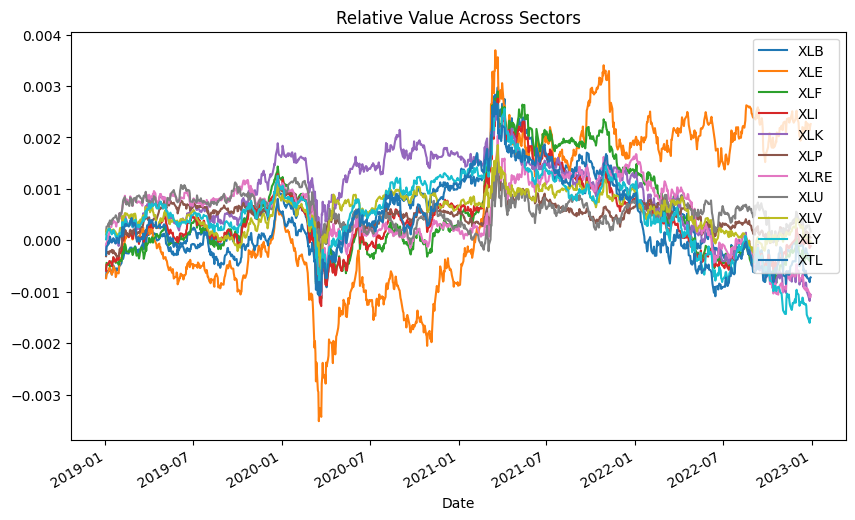

In [ ]:
# Plot the relative values
rolling_relative_scores.plot(figsize=(10, 6), title='Relative Value Across Sectors')
# Show the plot
plt.show()

# Centrality and Relative Value Combined

In [ ]:
# Calculate Centrality
def retrieve_sp500_list():
    data = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    table = data[0]
    return table

def download_sector_data(symbols, start_date, end_date):
    df_sectors = yf.download(symbols, start=start_date, end=end_date)['Adj Close']
    df_sectors = df_sectors.pct_change().dropna()
    return df_sectors

def preprocess_data(df_sectors):
    scaler = StandardScaler()
    df_sectors_scaled = scaler.fit_transform(df_sectors)
    return df_sectors_scaled

def calculate_weight(market_cap):
    weights = [cap / np.sum(market_cap) for cap in market_cap]
    return weights

def calculate_weighted_df(df_sectors, market_cap):
    weights = calculate_weight(market_cap)
    sector_weights = dict(zip(df_sectors.columns, [weight * 100 for weight in weights]))

    weighted_df = df_sectors.copy()

    for sector in df_sectors.columns:
        weighted_df.loc[:, sector] *= np.sqrt(sector_weights[sector])

    return weighted_df

def calculate_centrality_score(X, n=2):
    pca_model = PCA(n_components=n)
    pca_model.fit(X)
    EV = pca_model.components_
    AR = pca_model.explained_variance_ratio_

    C_list = []
    for i in range(X.shape[1]):
        C_num = sum(AR[j] * abs(EV[j][i]) / sum(abs(EV[j][k]) for k in range(X.shape[1])) for j in range(n))
        C_denom = sum(AR[j] for j in range(n))
        C_list.append(C_num / C_denom)

    return C_list

# Calculate Relative Value

def fetch_sector_data(symbols, start_date, end_date):
    df_sectors_prices = yf.download(symbols, start=start_date, end=end_date)['Adj Close']
    df_sectors = df_sectors_prices.pct_change().dropna()
    return df_sectors

def calculate_market_cap_weights(market_cap):
    weights = market_cap / np.sum(market_cap)
    return weights

def fetch_sector_current_price(symbols):
    sector_current_price = [si.get_live_price(sector) for sector in symbols]
    return sector_current_price

def fetch_sector_200DaySMA(symbols):
    sector_200DaySMA = [si.get_data(sector, interval='1d')['close'][-200:].mean() for sector in symbols]
    return sector_200DaySMA

def normalize_current_price(current_price, SMA):
    normalize = current_price / SMA
    return normalize

def calculate_relative_measure(normalized_prices, weights):
    normalized_prices = np.nan_to_num(normalized_prices, nan=0.0)
    weighted_average = np.dot(weights, normalized_prices)
    relative_measure = np.zeros_like(normalized_prices)
    nonzero_indices = (weighted_average != 0)
    relative_measure[nonzero_indices] = normalized_prices[nonzero_indices] / weighted_average[nonzero_indices]
    return relative_measure

def create_relative_scores_df(symbols, normalized_prices, weights):
    relative_measure = calculate_relative_measure(normalized_prices, weights)
    relative_scores = dict(zip(symbols, [np.around(r, 2) for r in relative_measure]))
    for asset in relative_scores:
        relative_scores[asset] = [relative_scores[asset]]
    scores_df = pd.DataFrame(data=relative_scores, index=['Relative_score'])
    scores_df = scores_df.transpose()
    return scores_df

def combine_centrality_relative_value(weighted_df, symbols, normalized_prices, weights):
    centrality_scores = calculate_centrality_score(weighted_df)
    scores_df = create_relative_scores_df(symbols, normalized_prices, weights)

    centrality_df = pd.DataFrame(data=centrality_scores, columns=['Centrality'], index=symbols)
    relative_df = create_relative_scores_df(symbols, normalized_prices, weights)

    combined_scores_df = pd.concat([centrality_df, relative_df], axis=1)
    print(combined_scores_df)

    combined_scores_df.index.name = 'Ticker'
    return combined_scores_df

def construct_portfolios(df_sectors, symbols, normalized_prices, weights):
    combined_scores_df = combine_centrality_relative_value(weighted_df, symbols, normalized_prices, weights)

    try:
        top_crowded = combined_scores_df.sort_values(by='Centrality', ascending=False).head(5).index
        top_overvalued = combined_scores_df.sort_values(by='Relative_score', ascending=False).head(5).index
    except KeyError as e:
        print(f"Error: {e}")
        return None, None, None

    if top_crowded.empty or top_overvalued.empty:
        print("Error: Top crowded or top overvalued is empty.")
        return None, None, None

    print("Top Five Crowded Sectors:", top_crowded)
    print("Top Five Overvalued Sectors:", top_overvalued)

    next_day_returns = df_sectors.shift(-1)

    no_bubble_portfolio = combined_scores_df[~combined_scores_df.index.isin(top_crowded.union(top_overvalued))]
    bubble_run_up_portfolio = combined_scores_df[combined_scores_df.index.isin(top_crowded) & ~combined_scores_df.index.isin(top_overvalued)]
    bubble_sell_off_portfolio = combined_scores_df[combined_scores_df.index.isin(top_crowded) & combined_scores_df.index.isin(top_overvalued)]

    return no_bubble_portfolio, bubble_run_up_portfolio, bubble_sell_off_portfolio, next_day_returns

# Impute Values below:
if __name__ == "__main__":
    # Input Selected 11 Sectors
    symbols = ['XLB', 'XLI', 'XLY', 'XLP', 'XLE', 'XLV', 'XLF', 'XLK', 'XTL', 'XLU', 'XLRE']
    # Input Market Capitalization respectively (Source: Bloomberg - As of 2Jan'18)
    market_cap = [5155.15,12969,13240.4,9152.23,18812.3,16832,32902.2,19697.5,44.97,7122.59,2392.39]
    # Input the timeframe
    start_date = "2018-01-01"
    end_date = "2023-01-01"

    sp500_list = retrieve_sp500_list()
    sector_data = download_sector_data(symbols, start_date, end_date)
    scaled_data = preprocess_data(sector_data)

    df_sectors = download_sector_data(symbols, start_date, end_date)

    weighted_df = calculate_weighted_df(df_sectors, market_cap)
    weighted_scores = calculate_centrality_score(weighted_df)

    weights = calculate_market_cap_weights(market_cap)

    df_sectors = fetch_sector_data(symbols, start_date, end_date)

    sector_current_price = fetch_sector_current_price(symbols)
    sector_200DaySMA = fetch_sector_200DaySMA(symbols)

    normalized_prices = [normalize_current_price(current_price, sma) for current_price, sma in zip(sector_current_price, sector_200DaySMA)]

    relative_measure = calculate_relative_measure(normalized_prices, weights)

    scores_df = create_relative_scores_df(symbols, normalized_prices, weights)

    df_sectors.index.names = ['Date']

    no_bubble_portfolio, bubble_run_up_portfolio, bubble_sell_off_portfolio, next_day_returns = construct_portfolios(df_sectors, symbols, normalized_prices, weights)

    print("***No Bubble Portfolio***:")
    print(no_bubble_portfolio)
    print("\n***Bubble Run-up Portfolio***:")
    print(bubble_run_up_portfolio)
    print("\n***Bubble Sell-off Portfolio***:")
    print(bubble_sell_off_portfolio)

[*********************100%%**********************]  11 of 11 completed
[*********************100%%**********************]  11 of 11 completed
[*********************100%%**********************]  11 of 11 completed
      Centrality  Relative_score
XLB     0.060969            0.99
XLI     0.161739            1.02
XLY     0.111937            1.04
XLP     0.082213            0.91
XLE     0.120174            0.93
XLV     0.077558            0.95
XLF     0.168037            1.03
XLK     0.112044            1.08
XTL     0.004191            0.98
XLU     0.064512            0.92
XLRE    0.036627            1.02
Top Five Crowded Sectors: Index(['XLF', 'XLI', 'XLE', 'XLK', 'XLY'], dtype='object', name='Ticker')
Top Five Overvalued Sectors: Index(['XLK', 'XLY', 'XLF', 'XLI', 'XLRE'], dtype='object', name='Ticker')
***No Bubble Portfolio***:
        Centrality  Relative_score
Ticker                            
XLB       0.060969            0.99
XLP       0.082213            0.91
XLV       0.077558  

# Back-Testing for Sectors

[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  2 of 2 completed
***No Bubble Portfolio***:
Index(['XLP', 'XLV'], dtype='object', name='Ticker')

***Bubble Run-up Portfolio***:
Index(['XLE'], dtype='object', name='Ticker')

***Bubble Sell-off Portfolio***:
Index(['XLI', 'XLF'], dtype='object', name='Ticker')


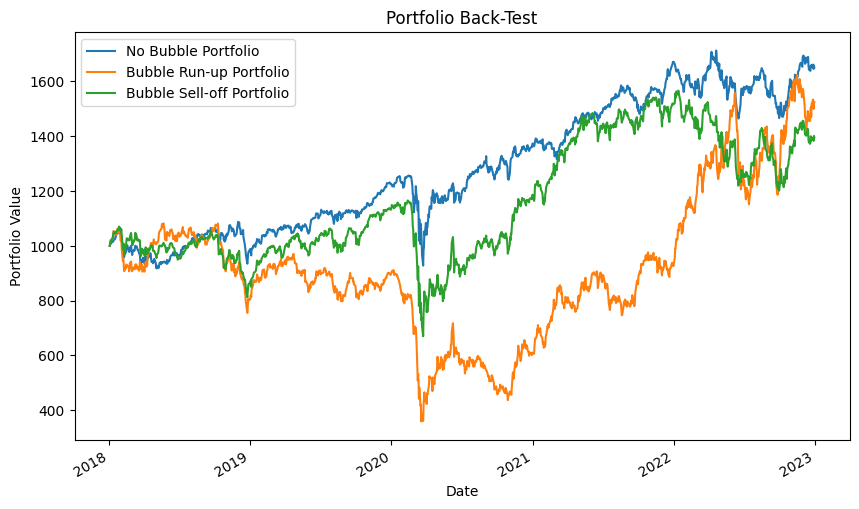

In [ ]:
def backtest_portfolio(portfolio, start_date, end_date, rebalance_freq='Q', initial_value=1000):
    # Download historical price data for the selected sectors
    prices = yf.download(portfolio.index.tolist(), start=start_date, end=end_date)['Adj Close']

    # Initialize portfolio values
    portfolio_values = []

    # Create a DataFrame to store portfolio values
    portfolio_df = pd.DataFrame(index=prices.index, columns=['Portfolio Value'])
    portfolio_df.iloc[0] = initial_value

    # Back-test loop
    for i in range(1, len(portfolio_df)):
        # Calculate the quarter-end date
        rebalance_date = portfolio_df.index[i] - pd.offsets.QuarterEnd()

        # Select equal weights for portfolio for the current date
        weights = 1/len(portfolio)

        # Calculate portfolio value based on weights and asset prices
        returns = prices.iloc[i] / prices.iloc[i - 1] - 1
        portfolio_value = portfolio_df.iloc[i - 1]['Portfolio Value'] * (1 + (weights * returns).sum())
        portfolio_df.iloc[i] = portfolio_value

    return portfolio_df

# Select 2 sectors from each portfolio
no_bubble_selected = no_bubble_portfolio.sort_values(by='Centrality', ascending=False).head(2).index
bubble_run_up_selected = bubble_run_up_portfolio.sort_values(by='Relative_score', ascending=False).head(2).index
bubble_sell_off_selected = bubble_sell_off_portfolio.sort_values(by='Relative_score', ascending=True).head(2).index

# Combine selected sectors for back-testing
selected_sectors = no_bubble_selected.union(bubble_run_up_selected).union(bubble_sell_off_selected)

# Define back-testing period
start_date_backtest = "2018-01-01"
end_date_backtest = "2023-01-01"

# Back-test each portfolio with an initial value of 1000
no_bubble_backtest = backtest_portfolio(no_bubble_portfolio.loc[no_bubble_selected], start_date_backtest, end_date_backtest, initial_value=1000)
bubble_run_up_backtest = backtest_portfolio(bubble_run_up_portfolio.loc[bubble_run_up_selected], start_date_backtest, end_date_backtest, initial_value=1000)
bubble_sell_off_backtest = backtest_portfolio(bubble_sell_off_portfolio.loc[bubble_sell_off_selected], start_date_backtest, end_date_backtest, initial_value=1000)

print("***No Bubble Portfolio***:")
print(no_bubble_selected)
print("\n***Bubble Run-up Portfolio***:")
print(bubble_run_up_selected)
print("\n***Bubble Sell-off Portfolio***:")
print(bubble_sell_off_selected)

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
no_bubble_backtest['Portfolio Value'].plot(label='No Bubble Portfolio')
bubble_run_up_backtest['Portfolio Value'].plot(label='Bubble Run-up Portfolio')
bubble_sell_off_backtest['Portfolio Value'].plot(label='Bubble Sell-off Portfolio')
plt.title('Portfolio Back-Test')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()